# Selective Capacitated Fair Pickup and Delivery Problem - Part II


## 0.) Introduction & setup

### Code Setup

In [159]:
from src.instance import Instance
from src.blabla import *

import copy

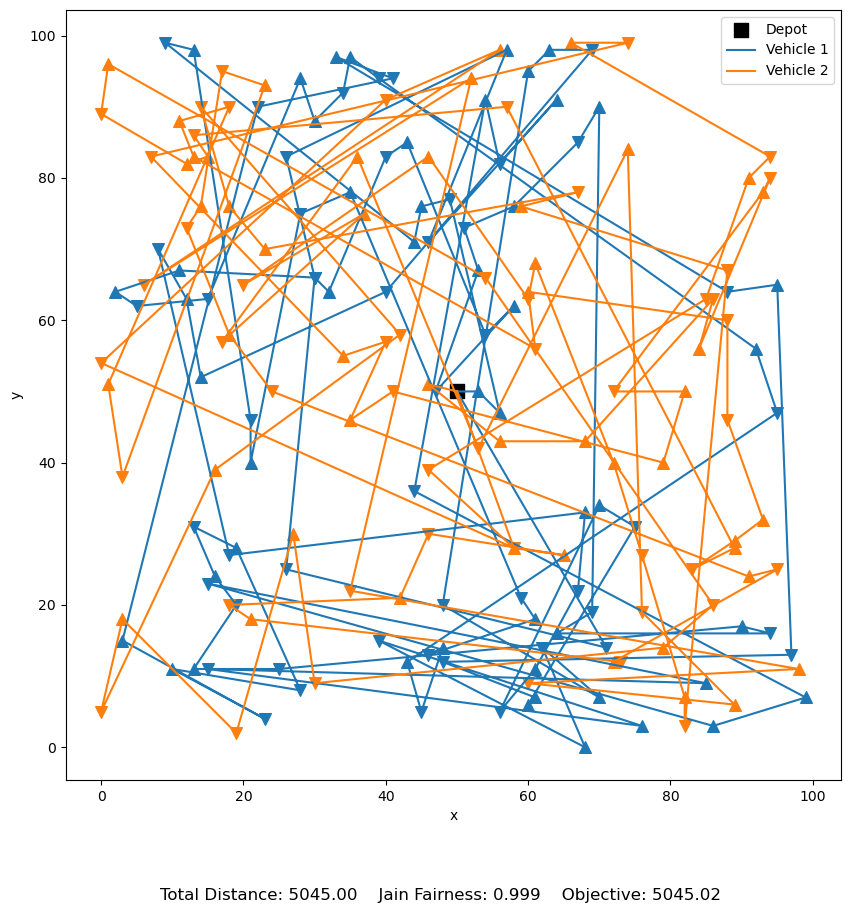

In [160]:
aaa = Instance("instances/100/competition/instance61_nreq100_nveh2_gamma91.txt")
routes = nearest_neighbor_heuristic(aaa)
plot_routes(aaa, routes)

## 1.) Implementing two algorithms

## Adaptive Large Neighborhood Search

We start by defining a class for our route representation

In [158]:
aaa = Instance("instances/100/competition/instance61_nreq100_nveh2_gamma91.txt")
routes = nearest_neighbor_heuristic(aaa)

r = Route(aaa)
r.load_from_array(routes[0])
print(len(r.nodes))
print(r.load_profile)
print(r.try_insert_request(3, 1, 1))
r.insert_request(3, 1, 1)
print(r.load_profile)

98
[29, 79, 50, 73, 98, 48, 86, 48, 80, 48, 67, 44, 78, 59, 76, 51, 89, 55, 81, 43, 71, 54, 76, 97, 71, 43, 63, 90, 63, 96, 76, 97, 64, 84, 64, 94, 64, 98, 64, 92, 70, 97, 69, 91, 64, 96, 74, 93, 72, 96, 64, 93, 72, 91, 72, 48, 88, 59, 100, 81, 41, 64, 91, 64, 84, 64, 84, 64, 82, 59, 18, 48, 93, 63, 45, 71, 91, 65, 84, 64, 91, 46, 79, 52, 82, 52, 77, 96, 71, 100, 71, 100, 67, 96, 77, 58, 29, 0]
129
[29, 57, 29, 79, 50, 73, 98, 48, 86, 48, 80, 48, 67, 44, 78, 59, 76, 51, 89, 55, 81, 43, 71, 54, 76, 97, 71, 43, 63, 90, 63, 96, 76, 97, 64, 84, 64, 94, 64, 98, 64, 92, 70, 97, 69, 91, 64, 96, 74, 93, 72, 96, 64, 93, 72, 91, 72, 48, 88, 59, 100, 81, 41, 64, 91, 64, 84, 64, 84, 64, 82, 59, 18, 48, 93, 63, 45, 71, 91, 65, 84, 64, 91, 46, 79, 52, 82, 52, 77, 96, 71, 100, 71, 100, 67, 96, 77, 58, 29, 0]


In [193]:
class Route:
    def __init__(self, instance):
        self.instance = instance
        self.capacity = instance.C

        self.nodes = []              # sequence of pickup/delivery node IDs
        self.requests = set()        # request IDs served by this route

        self.load_profile = []      # load after each node
        self.min_slack = instance.C    # min remaining capacity (thightest point along the route)
        self.distance = 0.0          # route length

    def recompute(self):
        load = 0
        self.load_profile = []
        self.min_slack = self.capacity

        for node in self.nodes:
            if node <= self.instance.n:
                load += self.instance.requests[node - 1]["demand"]
            else:
                load -= self.instance.requests[node - self.instance.n - 1]["demand"]

            if load < 0 or load > self.capacity:
                raise ValueError("Infeasible route")

            self.load_profile.append(load)
            self.min_slack = min(self.min_slack, self.capacity - load)
        self.distance = get_total_distance(self.instance, self.nodes)

    def load_from_array(self, route):
        # this function assumes valid input, because the input will mainly come from algorithms that are already tested and tried out
        self.nodes = route
        self.requests = {i for i in route if 1 <= i <= self.instance.n}
        self.recompute()

    def copy(self):
        return copy.deepcopy(self)

    def remove_request(self, req_id):
        if not req_id in self.requests:
            raise Exception("req_id not in this route!")
        self.nodes = [n for n in self.nodes if n != req_id and n != (req_id + self.instance.n)]
        self.requests.remove(req_id)
        self.recompute()
        print("removed request ", req_id)

    def try_insert_request(self, req_id, pick_up_idx_pos, drop_off_idx_pos):
        # we start counting with 0!!!!
        if req_id > self.instance.n or req_id in self.requests:
            #raise Exception("Invalid req id!")
            return None
        if drop_off_idx_pos < pick_up_idx_pos:
            #raise Exception("drop off before pick up!")
            return None
        preliminary_route = self.nodes.copy()
        preliminary_route.insert(pick_up_idx_pos, req_id)
        preliminary_route.insert(drop_off_idx_pos + 1, req_id + self.instance.n)
        preliminary_load = 0
        preliminary_load_profile = []
        preliminary_min_slack = self.capacity
        for idx in preliminary_route:   # can be made more efficient I know
            if idx <= self.instance.n:
                preliminary_load += self.instance.requests[idx - 1]["demand"] # fucking off-by-one
                if (self.instance.C - preliminary_load) <= preliminary_min_slack:
                    preliminary_min_slack = self.instance.C - preliminary_load
                if preliminary_load > self.instance.C:
                    return None
            else:
                preliminary_load -= self.instance.requests[idx - self.instance.n - 1]["demand"]
                if preliminary_load < 0:
                    return None
            preliminary_load_profile.append(preliminary_load)
        #self.load_profile = preliminary_load_profile
        #self.min_slack = preliminary_min_slack
        #self.nodes = preliminary_route
        new_distance = get_total_distance(self.instance, preliminary_route)
        return new_distance - self.distance

    def insert_request(self, req_id, p_pos, d_pos):
        delta = self.try_insert_request(req_id, p_pos, d_pos)
        if delta is not None:
            pickup = req_id
            dropoff = req_id + self.instance.n

            self.nodes.insert(p_pos, pickup)
            self.nodes.insert(d_pos + 1, dropoff)
            self.requests.add(req_id)
            self.recompute()

    def marginal_cost(self, req_id):
        original_distance = self.distance
        temp_nodes = [n for n in self.nodes if n != req_id and n != req_id  + self.instance.n]
        new_distance = get_total_distance(self.instance, temp_nodes)
        return original_distance - new_distance


In [194]:
class Solution:
    def __init__(self, instance):
        self.instance = instance
        self.routes = []

        self.unserved_requests = set(r["index"] for r in instance.requests)

        self.total_cost = 0.0
        self.total_dist = 0.0
        self.fairness = 0.0

        # Fast lookup
        self.request_to_route = {} # tells us in which route we can find which request

    def load_from_arrays(self, routes):
        self.total_cost, self.total_dist, self.fairness = 0.0, 0.0, 0.0 # resetting everything
        self.unserved_requests = set(r["index"] for r in self.instance.requests)
        self.routes = []
        assert len(routes) == self.instance.n_k
        for r_idx, r in enumerate(routes):
            route = Route(self.instance)
            route.load_from_array(r)
            self.routes.append(route)
            self.total_dist += route.distance
            for req in route.requests:
                self.unserved_requests.remove(req)
                self.request_to_route[req] = r_idx
        self.fairness = get_Jain_fairness(self.instance, routes)
        self.total_cost = objective_function(self.instance, routes)

    def copy(self):
        return copy.deepcopy(self)

    def recompute_cost(self):
        self.total_cost, self.total_dist, self.fairness = 0.0, 0.0, 0.0 # resetting everything
        self.unserved_requests = set(r["index"] for r in self.instance.requests)
        #self.request_to_route = {} ToDo: reload requests_to_route!
        routes_as_array = []
        for route in self.routes:
            route.recompute()
            self.total_dist += route.distance
            routes_as_array.append(route.nodes)
            for req in route.requests:
                self.unserved_requests.remove(req)
        self.fairness = get_Jain_fairness(self.instance,routes_as_array)
        self.total_cost = objective_function(self.instance, routes_as_array)
        assert self.is_feasible()
        assert len(self.routes) == self.instance.n_k

    def is_feasible(self):
        # checking first condition - The vehicle capacity must never be exceeded at any point along the route
        # since all routes are already checked, we can assume this is true
        # checking second condition -  Each served request must be handled in its entirety by a single vehicle.
        # based on the design of the Route class, we also assume this is true
        # thirdly, at least gamma requests have to be served
        if len(self.unserved_requests) + self.instance.gamma <= self.instance.n:
            return True
        else:
            return False

    def plot(self):
        routes_as_array = [r.nodes for r in self.routes]
        plot_routes(self.instance, routes_as_array)



In [232]:
aaa = Instance("instances/100/competition/instance61_nreq100_nveh2_gamma91.txt")
routes = nearest_neighbor_heuristic(aaa)
s = Solution(aaa)
s.load_from_arrays(routes)
s.recompute_cost()

### Destroy operators

In [196]:
def random_removal(solution, q):
    removed = set()
    all_requests = list(
        req for r in solution.routes for req in r.requests
    )
    random.shuffle(all_requests)

    for req in all_requests[:q]:
        route_idx = solution.request_to_route[req]
        del solution.request_to_route[req]
        route = solution.routes[route_idx]
        route.remove_request(req)
        solution.unserved_requests.add(req)
        removed.add(req)

    return removed

In [197]:
random_removal(s, 3)

removed request  3
removed request  50
removed request  40


{3, 40, 50}

In [199]:
def worst_removal(solution, q):
    candidates = []

    for route in solution.routes:
        for req in route.requests:
            delta = route.marginal_cost(req)
            candidates.append((delta, req))

    candidates.sort(reverse=True)
    removed = set()

    for _, req in candidates[:q]:
        route_idx = solution.request_to_route[req]
        del solution.request_to_route[req]
        route = solution.routes[route_idx]
        route.remove_request(req)
        solution.unserved_requests.add(req)
        removed.add(req)

    return removed

In [204]:
worst_removal(s, 1)

removed request  30
removed request  94
removed request  39
removed request  65
removed request  28
removed request  69
removed request  15
removed request  14
removed request  95
removed request  59


{14, 15, 28, 30, 39, 59, 65, 69, 94, 95}

In [211]:
def shaw_removal(solution, q):
    removed = set()
    all_requests = list(
        req for r in solution.routes for req in r.requests
    )
    seed = random.choice(all_requests)
    removed.add(seed)

    def relatedness(r1, r2):
        p1 = solution.instance.requests[r1]["pick_up"]
        p2 = solution.instance.requests[r2]["pick_up"]
        return a(p1, p2)


    while len(removed) < q:
        candidates = [
            r for r in all_requests if r not in removed
        ]
        candidates.sort(key=lambda r: relatedness(seed, r))
        removed.add(candidates[0])

    for req in removed:
        route_idx = solution.request_to_route[req]
        route = solution.routes[route_idx]
        del solution.request_to_route[req]
        route.remove_request(req)
        solution.unserved_requests.add(req)

    return removed

In [212]:
shaw_removal(s, 3)

removed request  51
removed request  37
removed request  23


{23, 37, 51}

### Repair Operators

In [223]:
def best_insertion_for_route(route, req, max_gap=5):
    best_delta = None
    best_pos = None

    L = len(route.nodes)

    for p in range(L + 1):
        for d in range(p + 1, min(p + max_gap, L + 2)):
            delta = route.try_insert_request(req, p, d)
            if delta is not None:
                if best_delta is None or delta < best_delta:
                    best_delta = delta
                    best_pos = (p, d)

    return best_delta, best_pos


def greedy_repair(solution, max_gap=5):
    while len(solution.unserved_requests) > solution.instance.n - solution.instance.gamma:
        best = None

        for req in list(solution.unserved_requests):
            for route_idx, route in enumerate(solution.routes):
                delta, pos = best_insertion_for_route(route, req, max_gap)
                if pos is not None:
                    if best is None or delta < best[0]:
                        best = (delta, req, route_idx, pos)

        if best is None:
            break

        _, req, route_idx, (p, d) = best
        solution.routes[route_idx].insert_request(req, p, d)
        solution.unserved_requests.remove(req)
        solution.request_to_route[req] = route_idx


In [245]:
shaw_removal(s, 5)
greedy_repair(s)
s.plot()

IndexError: list index out of range

In [11]:
def regret_3_repair(solution, instance):
    while solution.unserved_requests: # ToDo: again, don't serve all
        best_req = None
        best_regret = -float("inf")
        best_route = None

        for req in solution.unserved_requests:
            costs = []

            for route in solution.routes:
                delta = route.try_insert_request(req, instance)
                if delta is not None:
                    costs.append((delta, route))

            if len(costs) < 1:
                continue

            costs.sort(key=lambda x: x[0])
            c1 = costs[0][0]
            c3 = costs[2][0] if len(costs) >= 3 else costs[-1][0]
            regret = c3 - c1

            if regret > best_regret:
                best_regret = regret
                best_req = req
                best_route = costs[0][1]

        if best_req is None:
            break

        best_route.insert_request(best_req, instance)
        solution.unserved_requests.remove(best_req)


### === ALNS ===

In [ ]:
class OperatorPool:
    def __init__(self, operators):
        self.ops = operators
        self.weights = [1.0] * len(operators)
        self.scores = [0.0] * len(operators)

    def select(self):
        return random.choices(
            range(len(self.ops)),
            weights=self.weights,
            k=1
        )[0]

    def update(self, idx, reward):
        self.scores[idx] += reward

    def adapt(self, rho=0.1):
        for i in range(len(self.weights)):
            self.weights[i] = (
                (1 - rho) * self.weights[i] + rho * self.scores[i]
            )
            self.scores[i] = 0.0

In [12]:
@dataclass
class ALNSParams:
    T0: float
    cooling: float
    destroy_fraction: float
    rho: float
    reward_best: float
    reward_accept: float
    reward_reject: float
    regret_k: int

In [ ]:
def alns(instance, initial_solution, params, iters=1_000):
    def accept(new, current, temperature):
        if new.total_cost < current.total_cost:
            return True
        delta = new.total_cost - current.total_cost
        return random.random() < math.exp(-delta / temperature)

    destroy_ops = OperatorPool([
        lambda s: random_removal(s, q=params.destroy_fraction),
        lambda s: worst_removal(s, q=params.destroy_fraction),
        lambda s: shaw_removal(s, instance, q=params.destroy_fraction),
    ])

    repair_ops = OperatorPool([
        lambda s: greedy_repair(s, instance),
        lambda s: regret_3_repair(s, instance),
    ])

    current = initial_solution
    best = current.copy()
    T = params.T0

    for it in range(iters):
        new = current.copy()

        d = destroy_ops.select()
        r = repair_ops.select()

        destroy_ops.ops[d](new)
        repair_ops.ops[r](new)

        new.recompute_costs()

        if not new.is_feasible():
            continue

        if accept(new, current, T):
            current = new
            reward = params.reward_accept

            if new.total_cost < best.total_cost:
                best = new.copy()
                reward = params.reward_best
        else:
            reward = params.reward_reject

        destroy_ops.update(d, reward)
        repair_ops.update(r, reward)

        if it % 100 == 0:
            destroy_ops.adapt()
            repair_ops.adapt()
            T *= params.cooling  # cooling

    return best

## 2.) Experimenting with different fairness mesaures

### Min-Max Fairness

### Gini coefficient

## 3.) Tuning our algorithms

## 4.) Testing our algortihms

## 5.) Comparing algorithms